<a href="https://colab.research.google.com/github/malickl/Analyse-Ventes-Librairie/blob/main/Analyse_Ventes_Librairie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [98]:
cust = pd.read_csv('customers.csv')
prod = pd.read_csv('products.csv')
tran = pd.read_csv('transactions.csv')

In [99]:
for i in [cust, prod, tran]:
  print(f"{i.head()}, {i.shape}")
  print("--------------------------------------------------------")

  client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943, (8623, 3)
--------------------------------------------------------
  id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0, (3287, 3)
--------------------------------------------------------
  id_prod                        date session_id client_id
0  0_1483  2021-04-10 18:37:28.723910    s_18746    c_4450
1   2_226  2022-02-03 01:55:53.276402   s_159142     c_277
2   1_374  2021-09-23 15:13:46.938559    s_94290    c_4270
3  0_2186  2021-10-17 03:27:18.783634   s_105936    c_4597
4  0_1351  2021-07-17 20:34:25.800563    s_63642    c_1242, (337016, 4)
--------------------------------------------------------


## Vérification des valeurs manquantes dans le dataset

In [100]:
for i in [cust, prod, tran]:
  print(i.info())
  print("--------------------------------------------------------")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB
None
--------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB
None
--------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------  

Aucune valeur manquante n'a été détectée dans le dataset

## Examen des valeurs aberrantes

In [101]:
dataframes = [cust, prod, tran]

for df in dataframes:
    # Appliquer le calcul de l'IQR seulement sur les colonnes numériques
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Identifier les outliers pour la colonne actuelle
        mask = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))

        # Vérifier s'il y a des outliers dans la colonne actuelle et imprimer le résultat
        print(f"Outliers in {column}: {mask.any()}: {mask.sum()}")


Outliers in birth: False: 0
Outliers in price: True: 302
Outliers in categ: False: 0


In [102]:
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(prod.select_dtypes(include=[np.number])))
outliers = z > 3
print(f"{outliers.any()} : {outliers.sum()}")


price     True
categ    False
dtype: bool : price    97
categ     0
dtype: int64


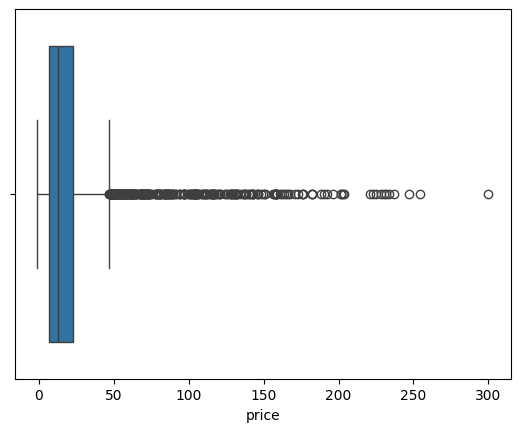

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.boxplot(x=prod['price'])
plt.show()


Selon la méthode du z-score, 97 valeurs aberrantes ont été identifiées dans le dataset. Par ailleurs, en appliquant la méthode de l'écart interquartile (IQR), 307 valeurs aberrantes ont été détectées. Afin de déterminer la méthode la plus adaptée, un examen de la distribution de la variable "price" est requis.

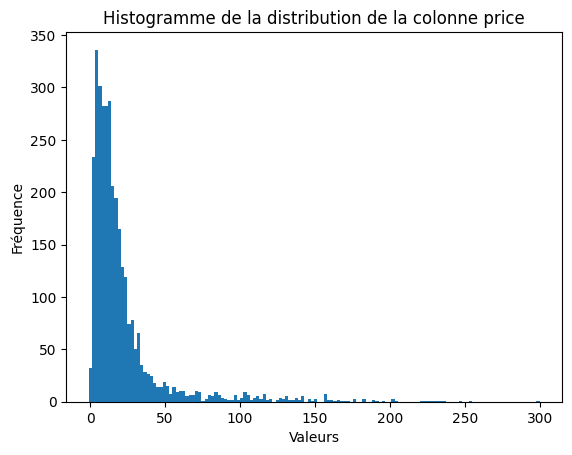

In [104]:
plt.hist(prod.price, bins='auto')
plt.title('Histogramme de la distribution de la colonne price')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

- Asymétrie à droite : La distribution des prix semble être asymétrique à droite. Cela signifie qu'il y a une queue plus longue vers les valeurs plus élevées.

- Concentration de valeurs basses : La majorité des valeurs sont concentrées dans les plus basses gammes de prix. Il y a des pics fréquents à l'extrémité inférieure de l'échelle des prix.

- Valeurs aberrantes possibles : Les barres qui s'étendent vers les valeurs plus élevées, particulièrement celles qui sont très isolées des autres, suggèrent la présence de valeurs aberrantes ou extrêmes.

- Non-normalité : La forme de la distribution n'est pas celle d'une courbe normale, qui serait plus symétrique et en forme de cloche.

In [105]:
prod['price'].describe()

count    3287.000000
mean       21.856641
std        29.847908
min        -1.000000
25%         6.990000
50%        13.060000
75%        22.990000
max       300.000000
Name: price, dtype: float64

L'écart-type s'élève à environ 29.85, ce qui est considérablement élevé en comparaison avec la moyenne. Cela suggère une large dispersion des données. Notamment, la valeur minimale enregistrée est de -1, ce qui est atypique étant donné que des prix négatifs ne sont généralement pas plausibles dans ce contexte.

In [106]:
prod[prod['price'] < 0]

,id_prod,price,categ
731,T_0,-1.0,0


Procédons à la suppression de cette anomalie

In [107]:
prod = prod.drop(prod[prod['price'] < 0].index)

Au vu de la distribution anormale de nos données, la méthode de l'écart interquartile (IQR) semble être la plus appropriée dans notre cas pour déterminer les valeurs aberrantes.

N'ayant pas davantage d'informations sur ce dataset, je suppose que les valeurs aberrantes font partie d'un groupe de produits de luxe et que leur implication dans l'analyse est essentielle.

In [108]:
# fusionnons les trois data set

# Fusionner le DataFrame des transactions avec celui des clients
transactions_customers_df = pd.merge(tran, cust, on='client_id', how='inner')

# Fusionner le résultat avec le DataFrame des produits
data = pd.merge(transactions_customers_df, prod, on='id_prod', how='inner')

data.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,4.99,0
1,0_1483,2021-12-27 11:11:12.123067,s_140787,c_5433,f,1981,4.99,0
2,0_1483,2021-10-27 04:56:38.293970,s_110736,c_857,m,1985,4.99,0
3,0_1483,2021-07-04 06:43:45.676567,s_57626,c_3679,f,1989,4.99,0
4,0_1483,2021-09-19 08:45:43.735331,s_92165,c_1609,m,1980,4.99,0


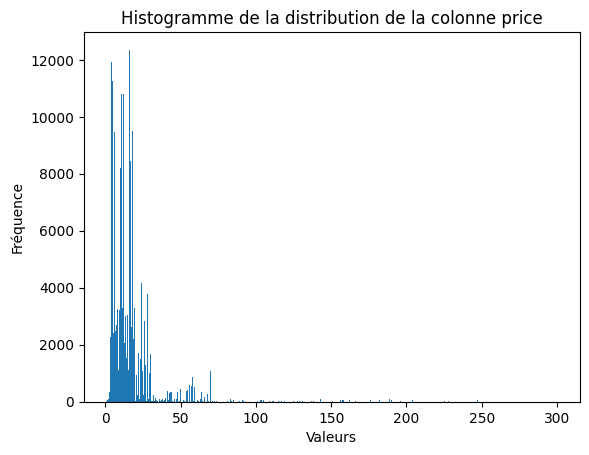

In [109]:
plt.hist(data.price, bins='auto')
plt.title('Histogramme de la distribution de la colonne price')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

In [110]:
data.describe()

,birth,price,categ
count,336713.000000,336713.000000,336713.000000
mean,1977.823568,17.215189,0.430156
std,13.524433,17.855445,0.591082
min,1929.000000,0.620000,0.000000
25%,1971.000000,8.610000,0.000000
50%,1980.000000,13.900000,0.000000
75%,1987.000000,18.990000,1.000000
max,2004.000000,300.000000,2.000000


- La moyenne du prix d'achat s'établit à 17,21, avec un écart-type de 17,87. Cela révèle une grande dispersion des données relatives aux prix d'achat, indiquant une large gamme de prix d'achat.

- L'année de naissance moyenne des clients est 1978.

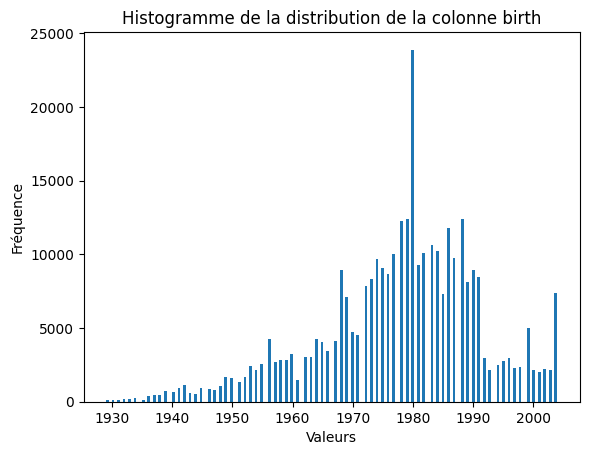

------


In [111]:
plt.hist(data.birth, bins='auto')
plt.title('Histogramme de la distribution de la colonne birth')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()
print("------")

L'histogramme révèle que la majorité des clients du magasin sont nés entre 1967 et 1990.

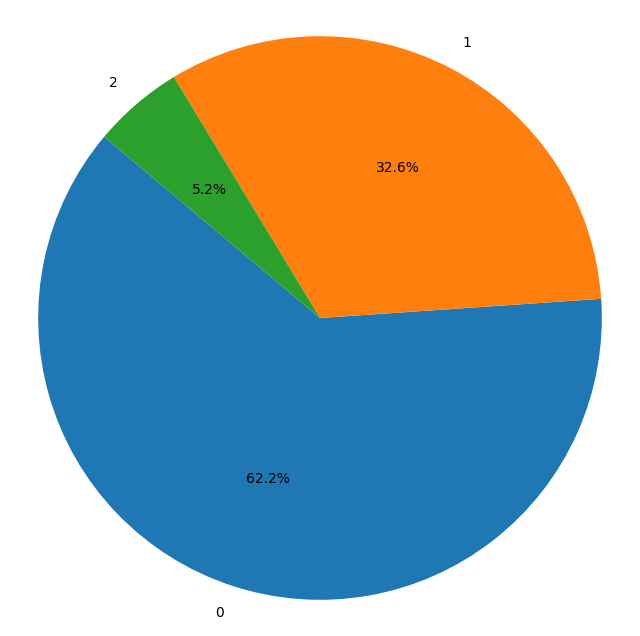

In [112]:
plt.figure(figsize=(8, 8))
plt.pie(data['categ'].value_counts(), labels=data['categ'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

On remarque également que les produits de catégorie 0 sont les plus achetés dans le magasin, suivis par les produits de catégorie 1. Ceux de catégorie 2 sont moins populaires en comparaison.

In [113]:
# vérifions si en une session il peut y avoir plusieurs achats
data[data['session_id'] == 's_18746']

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,4.99,0
10512,1_685,2021-04-10 18:25:09.319011,s_18746,c_4450,f,1977,15.99,1
13817,0_1395,2021-04-10 18:32:27.342375,s_18746,c_4450,f,1977,3.99,0


Je remarque la présence de trois catégories de produits. Il est possible qu'elles soient définies en fonction du prix.

In [114]:
data[data['categ'] == 0]


,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,4.99,0
1,0_1483,2021-12-27 11:11:12.123067,s_140787,c_5433,f,1981,4.99,0
2,0_1483,2021-10-27 04:56:38.293970,s_110736,c_857,m,1985,4.99,0
3,0_1483,2021-07-04 06:43:45.676567,s_57626,c_3679,f,1989,4.99,0
4,0_1483,2021-09-19 08:45:43.735331,s_92165,c_1609,m,1980,4.99,0
...,...,...,...,...,...,...,...,...
336694,0_1120,2021-11-05 14:40:32.119411,s_115135,c_3126,f,1986,21.84,0
336698,0_1379,2021-10-16 09:19:09.546713,s_105547,c_5425,f,1981,2.99,0
336706,0_549,2021-04-11 04:42:10.308957,s_18930,c_4202,f,1987,2.99,0
336708,0_1920,2021-04-13 18:36:10.252971,s_20115,c_7088,m,1987,25.16,0


À première vue, je remarque un produit de catégorie 0 vendu à 21€, ce qui semble contredire mon hypothèse. Je vais examiner cela de plus près.

In [115]:
data_0 = data[data['categ'] == 0]
data_1 = data[data['categ'] == 1]
data_2 = data[data['categ'] == 2]

In [116]:
for i in [data_0, data_1, data_2]:
  print(i.describe())
  print("----------------------------------------------")

               birth          price     categ
count  209426.000000  209426.000000  209426.0
mean     1978.102280      10.646828       0.0
std        11.203684       4.930030       0.0
min      1929.000000       0.620000       0.0
25%      1974.000000       6.300000       0.0
50%      1980.000000       9.990000       0.0
75%      1986.000000      14.450000       0.0
max      2004.000000      40.990000       0.0
----------------------------------------------
               birth          price     categ
count  109735.000000  109735.000000  109735.0
mean     1974.340876      20.480106       1.0
std        15.507490       7.568956       0.0
min      1929.000000       2.000000       1.0
25%      1964.000000      15.810000       1.0
50%      1975.000000      19.080000       1.0
75%      1986.000000      24.980000       1.0
max      2004.000000      80.990000       1.0
----------------------------------------------
              birth         price    categ
count  17552.000000  17552.000000  

Cependant, après avoir créé un dataset en fonction des catégories, je remarque que la moyenne des prix de chaque catégorie est différente et qu'elle évolue positivement.

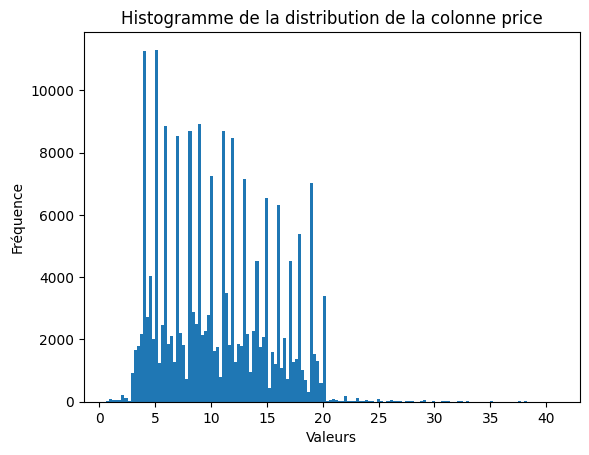

------


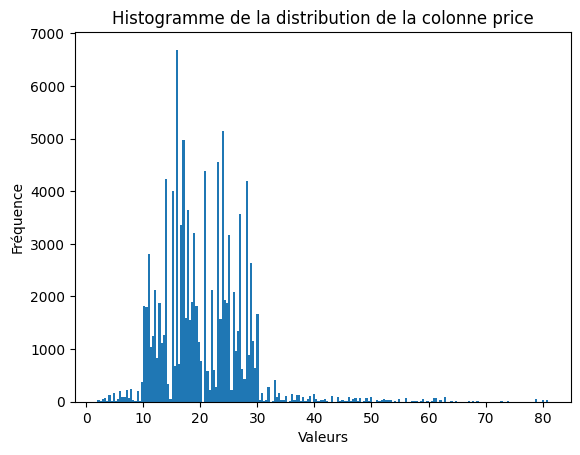

------


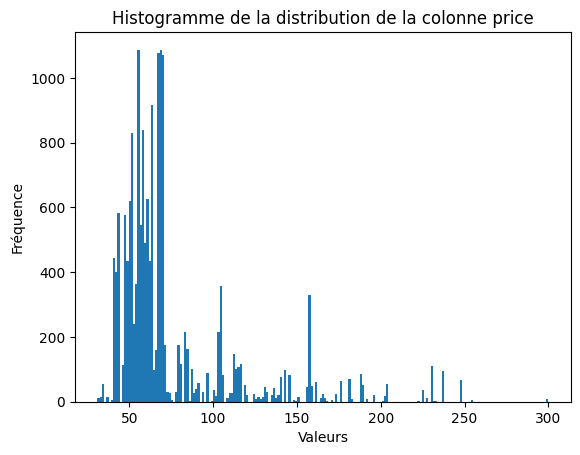

------


In [117]:
# verifons la distribution des prix en fonction de chaque catégorie.

for i in [data_0, data_1, data_2]:
  plt.hist(i.price, bins='auto')
  plt.title('Histogramme de la distribution de la colonne price')
  plt.xlabel('Valeurs')
  plt.ylabel('Fréquence')
  plt.show()
  print("------")

Je conclus que les catégories influent sur la gamme de prix de chaque produit. Plus la catégorie est élevée, plus elle présente une gamme de prix étendue, comme observé sur les histogrammes.

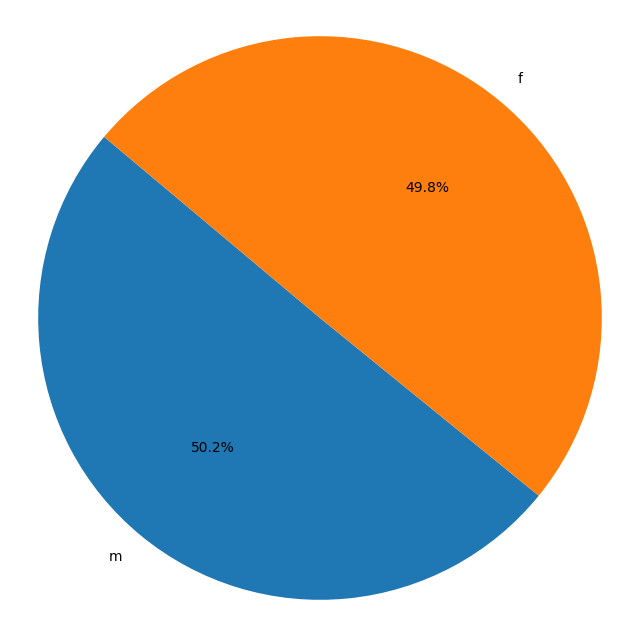

------


In [118]:
  plt.figure(figsize=(8, 8))
  plt.pie(data['sex'].value_counts(), labels=data['sex'].value_counts().index, autopct='%1.1f%%', startangle=140)
  plt.axis('equal')
  plt.show()
  print("------")

Nous avons autant de clients hommes que de clientes femmes dans le magasin.

## Y a-t-il un lien entre les catégories de produits et le sexe des clients ?

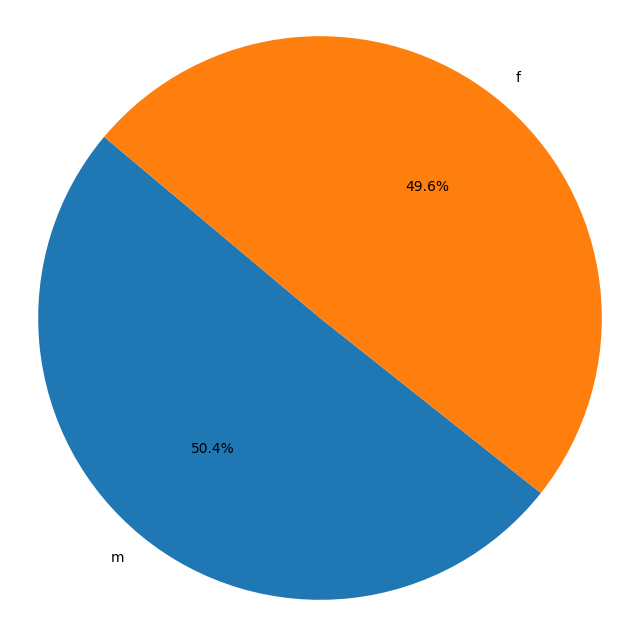

------


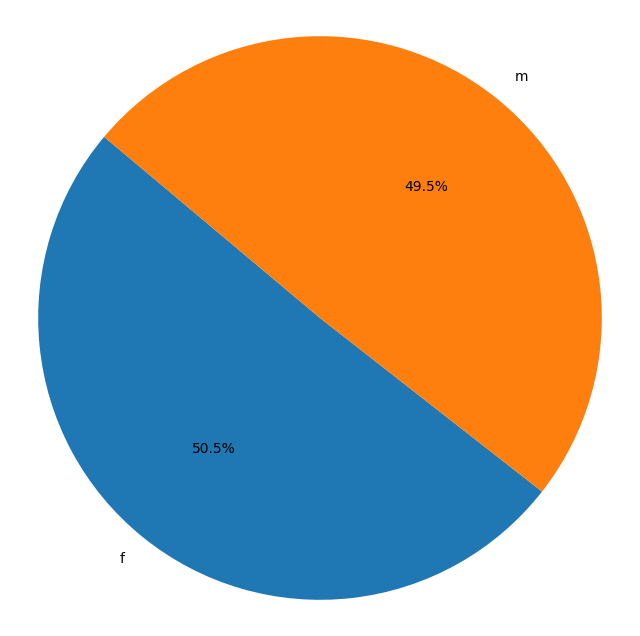

------


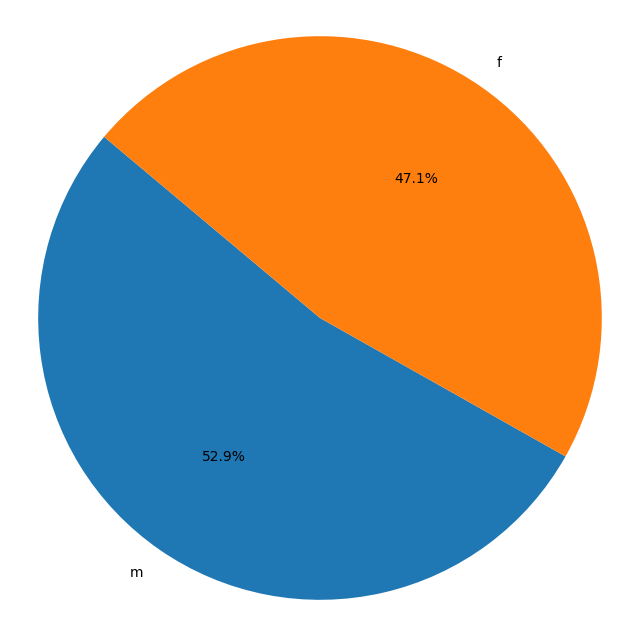

------


In [119]:
for i in [data_0, data_1, data_2]:
  # Créer le diagramme en camembert
  plt.figure(figsize=(8, 8))
  plt.pie(i['sex'].value_counts(), labels=i['sex'].value_counts().index, autopct='%1.1f%%', startangle=140)
  plt.axis('equal')
  plt.show()
  print("------")

Aucun lien n'a été observé entre le sexe des clients et les catégories de produits.

In [120]:
data.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,4.99,0
1,0_1483,2021-12-27 11:11:12.123067,s_140787,c_5433,f,1981,4.99,0
2,0_1483,2021-10-27 04:56:38.293970,s_110736,c_857,m,1985,4.99,0
3,0_1483,2021-07-04 06:43:45.676567,s_57626,c_3679,f,1989,4.99,0
4,0_1483,2021-09-19 08:45:43.735331,s_92165,c_1609,m,1980,4.99,0


In [121]:
data['date'] = pd.to_datetime(data['date'])

## Analyse des tendances quotidiennes des achats

### Analyse du revenu total

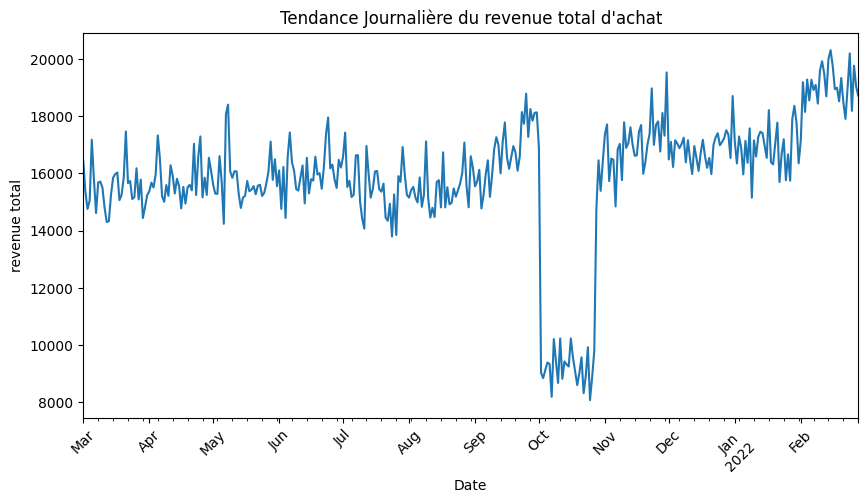

In [122]:
# Regroupement des données par jour et calcul du revenue total d'achat
daily_trend = data.resample('D', on='date').price.sum()

# Tracé de la tendance journalière
plt.figure(figsize=(10, 5))
daily_trend.plot(title="Tendance Journalière du revenue total d'achat")

# Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel("revenue total")
plt.show()

Une courbe présentant une tendance normale est observée tout au long de l'année jusqu'au mois d'octobre, où le revenu total quotidien des achats a connu une diminution drastique. Cependant, cette tendance a repris son cours normal en novembre. Une nette augmentation est même observée en février 2022.

### Analyse de la moyenne du revenu total

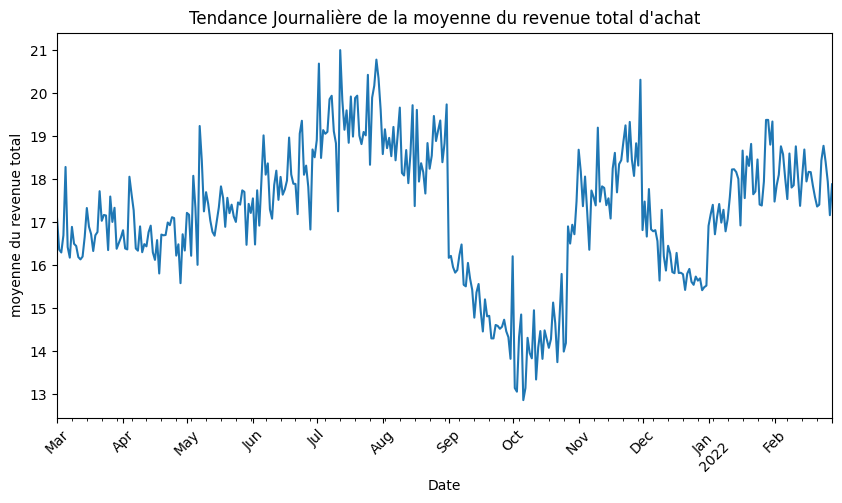

In [123]:
# Regroupement des données par jour et calcul de la moyenne du revenu total d'achat
daily_trend = data.resample('D', on='date').price.mean()

# Tracé de la tendance journalière
plt.figure(figsize=(10, 5))
daily_trend.plot(title="Tendance Journalière de la moyenne du revenue total d'achat")

# Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel("moyenne du revenue total")
plt.show()

Une baisse de la moyenne du revenu total journalier est observée au début du mois de septembre, suivie d'une reprise en novembre.

## Analyse des tendances hebdomadaires des achats

### Analyse du revenu total

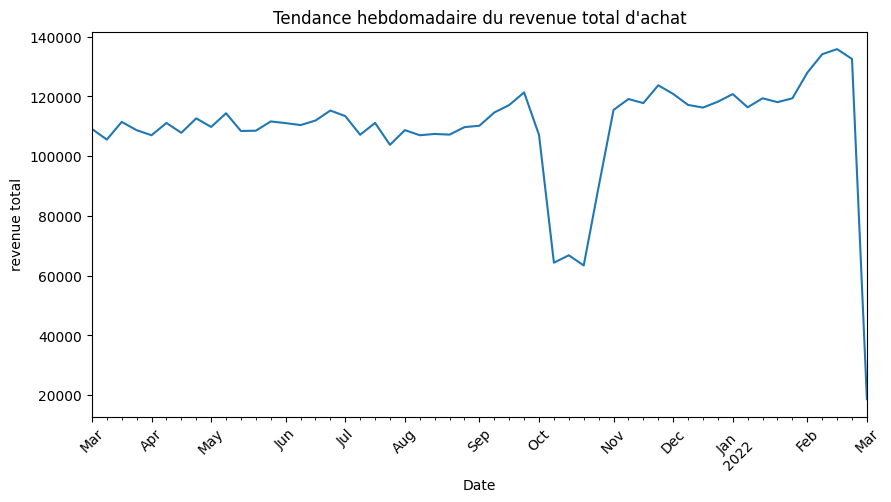

In [124]:
# Regroupement des données par semaine et calcul du revenue total d'achat
daily_trend = data.resample('W', on='date').price.sum()


plt.figure(figsize=(10, 5))
daily_trend.plot(title="Tendance hebdomadaire du revenue total d'achat")


plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel("revenue total")
plt.show()

Au niveau hebdomadaire, une baisse du revenu total est observée à partir de la fin du mois de septembre, suivie d'une reprise pour revenir au niveau initial début novembre.

### Analyse de la moyenne du revenu total

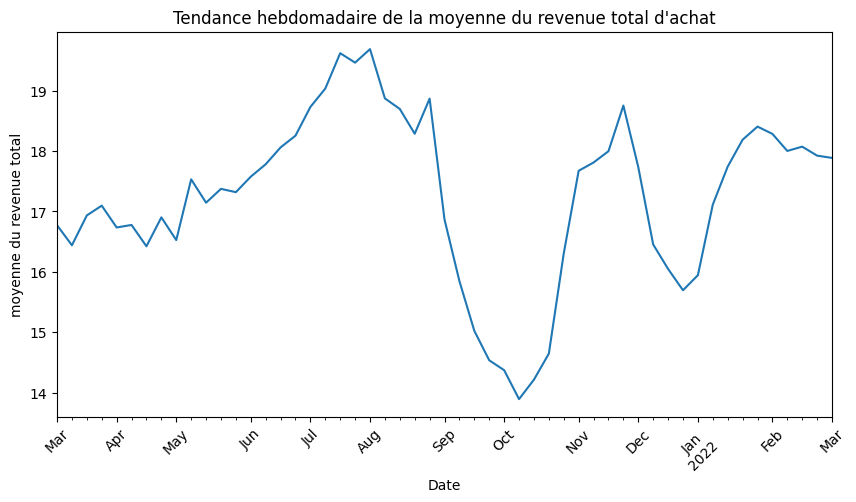

In [125]:
# Regroupement des données par semaine et calcul de la moyenne du revenu total d'achat
daily_trend = data.resample('w', on='date').price.mean()

plt.figure(figsize=(10, 5))
daily_trend.plot(title="Tendance hebdomadaire de la moyenne du revenue total d'achat")

# Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel("moyenne du revenue total")
plt.show()

Au niveau de la moyenne du revenu hebdomadaire, une hausse est observée début juin, suivie d'une baisse progressive jusqu'au début octobre, où elle atteint son point le plus bas. Ensuite, une reprise progressive survient après cette chute drastique, atteignant un pic fin novembre. Une chute progressive est observée en décembre, suivie d'une reprise en janvier 2022.

## Analyse des tendances mensuelles des achats

### Analyse du revenu total

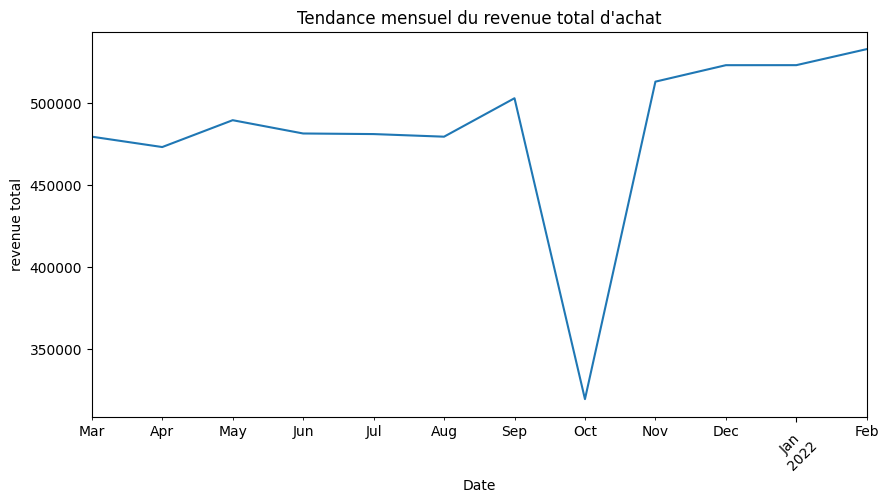

In [126]:
# Regroupement des données par mois et calcul du revenue total d'achat
daily_trend = data.resample('M', on='date').price.sum()

plt.figure(figsize=(10, 5))
daily_trend.plot(title="Tendance mensuel du revenue total d'achat")

plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel("revenue total")
plt.show()

Au niveau mensuel du revenu total, une courbe relativement stable est observée avec quelques variations mineures de mars à septembre. Ensuite, une chute drastique survient, atteignant son point le plus bas début octobre. Enfin, une reprise se produit à un niveau plus élevé que d'habitude.

### Analyse de la moyenne du revenu total

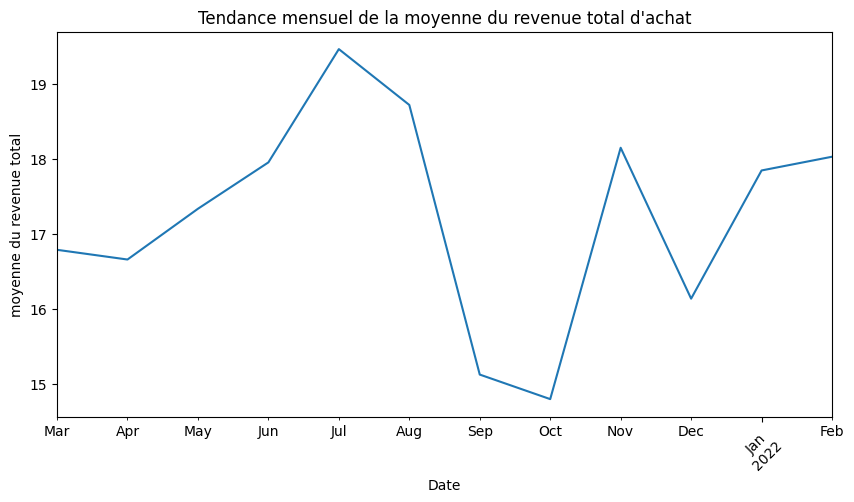

In [127]:
daily_trend = data.resample('M', on='date').price.mean()

plt.figure(figsize=(10, 5))
daily_trend.plot(title="Tendance mensuel de la moyenne du revenue total d'achat")

plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel("moyenne du revenue total")
plt.show()

Au niveau mensuel, on observe une augmentation de avril à juillet, suivie d'une chute de juillet à octobre. Ensuite, une augmentation est constatée d'octobre jusqu'à atteindre un pic début novembre, suivi d'une chute jusqu'à décembre. Enfin, une reprise est observée.

## Analyse des corrélations

### Corrélation entre l'âge du client et son nombre total d'achats

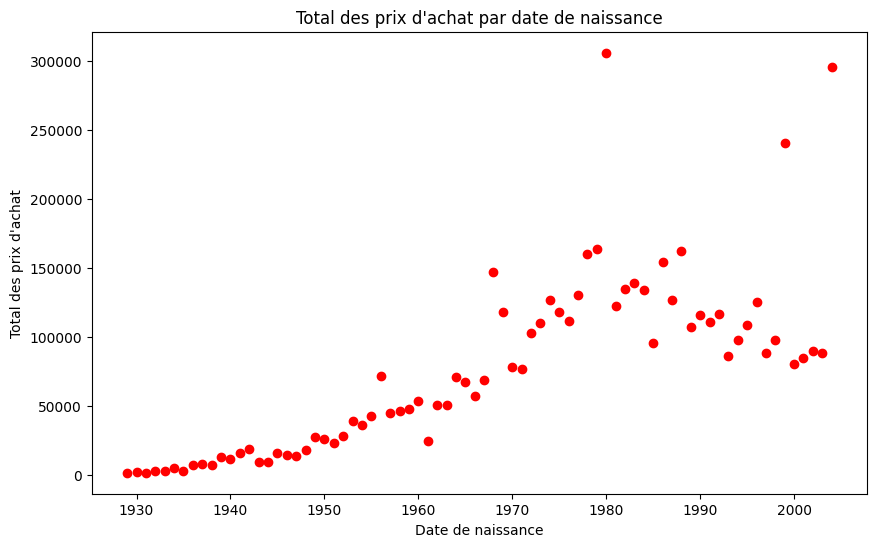

In [128]:
grouped_data = data.groupby('birth')['price'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(grouped_data['birth'], grouped_data['price'], color='red')
plt.title('Total des prix d\'achat par date de naissance')
plt.xlabel('Date de naissance')
plt.ylabel('Total des prix d\'achat')
plt.show()


Il semble exister une corrélation entre l'année de naissance du client et le montant total des achats.

In [129]:
correlation = grouped_data['birth'].corr(grouped_data['price'])
print(f"La corrélation entre l'age et le montant totat d'achat est : {correlation}")

La corrélation entre l'age et le montant totat d'achat est : 0.7746580837681794


### Corrélation entre l'âge du client et sa fréquence d'achat

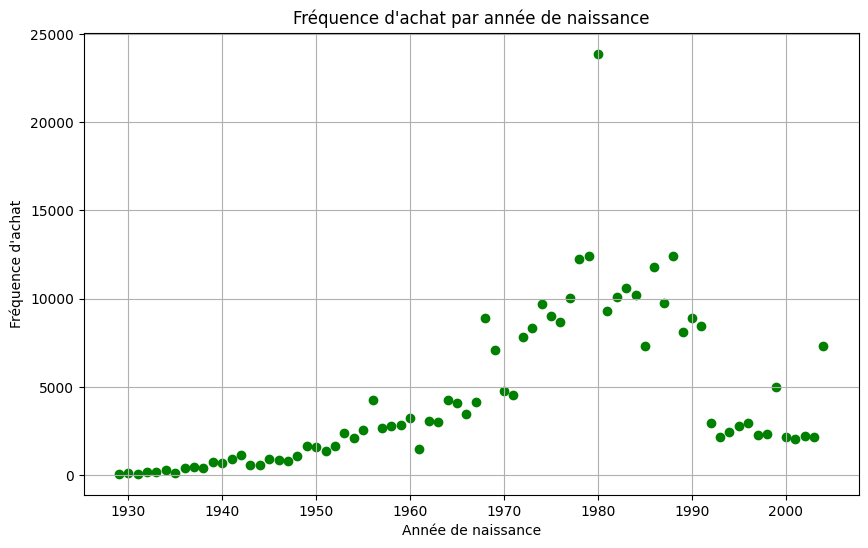

In [130]:
# Grouper les données par année de naissance et compter le nombre d'achats pour chaque groupe
grouped_data2 = data.groupby('birth').size().reset_index(name='frequence_achat')

# Visualiser les résultats avec un nuage de points
plt.figure(figsize=(10, 6))
plt.scatter(grouped_data2['birth'], grouped_data2['frequence_achat'], color='green')
plt.title('Fréquence d\'achat par année de naissance')
plt.xlabel('Année de naissance')
plt.ylabel('Fréquence d\'achat')
plt.grid(True)
plt.show()



Il semble également exister une corrélation entre l'âge des clients et leur fréquence d'achat.

In [131]:
correlation = grouped_data2['birth'].corr(grouped_data2['frequence_achat'])
print(f"La corrélation entre l'age et la frequence d'achat est : {correlation}")

La corrélation entre l'age et la frequence d'achat est : 0.5292865989339431


### Corrélation entre l'âge du client et la taille moyenne de leur panier.

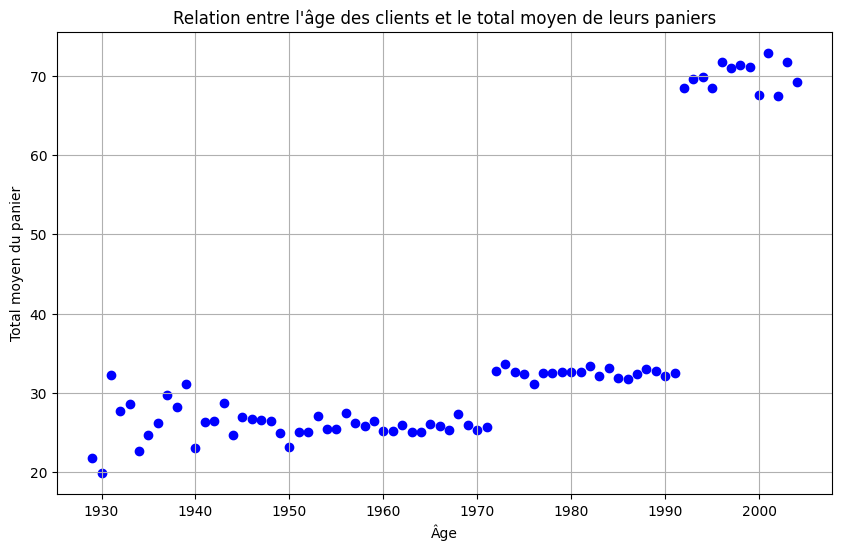

In [132]:
# Calculer le total du panier pour chaque session
total_panier_par_session = data.groupby('session_id')['price'].sum().reset_index(name='total_panier')

# Associer chaque session à son client_id
session_client = data[['session_id', 'client_id']].drop_duplicates()

# Fusionner pour obtenir le total du panier par client
total_panier_client = pd.merge(session_client, total_panier_par_session, on='session_id')

# Calculer le total moyen des paniers par client
moyen_panier_par_client = total_panier_client.groupby('client_id')['total_panier'].mean().reset_index(name='moyen_total_panier')

# Associer l'âge à chaque client
age_client = data[['client_id', 'birth']].drop_duplicates()

# Fusionner pour avoir l'âge et le moyen total du panier pour chaque client
age_moyen_panier = pd.merge(age_client, moyen_panier_par_client, on='client_id')

# Calculer le total moyen des paniers par âge
moyen_panier_par_age = age_moyen_panier.groupby('birth')['moyen_total_panier'].mean().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(moyen_panier_par_age['birth'], moyen_panier_par_age['moyen_total_panier'], color='blue')
plt.title('Relation entre l\'âge des clients et le total moyen de leurs paniers')
plt.xlabel('Âge')
plt.ylabel('Total moyen du panier')
plt.grid(True)
plt.show()

Nous observons trois groupes assez distincts en fonction des tranches d'âge. Les personnes nées entre 1930 et 1971 ont une moyenne de taille de panier entre 20 et 30. Ensuite, celles nées entre 1972 et 1991 ont une moyenne entre 30 et 40. Enfin, celles nées en 1992 et plus ont une moyenne nettement plus élevée par rapport aux autres, entre 65 et 75.

In [133]:
correlation = moyen_panier_par_age['birth'].corr(moyen_panier_par_age['moyen_total_panier'])
print(f"La corrélation entre l'age et la taille moyen du panier est : {correlation}")

La corrélation entre l'age et la taille moyen du panier est : 0.7394585096040315


Une corrélation de Spearman de 0,73 est observée, confirmant ainsi la relation entre l'âge et la taille moyenne du panier.

### Corrélation entre l'âge du client et la catégorie de produit achetée.

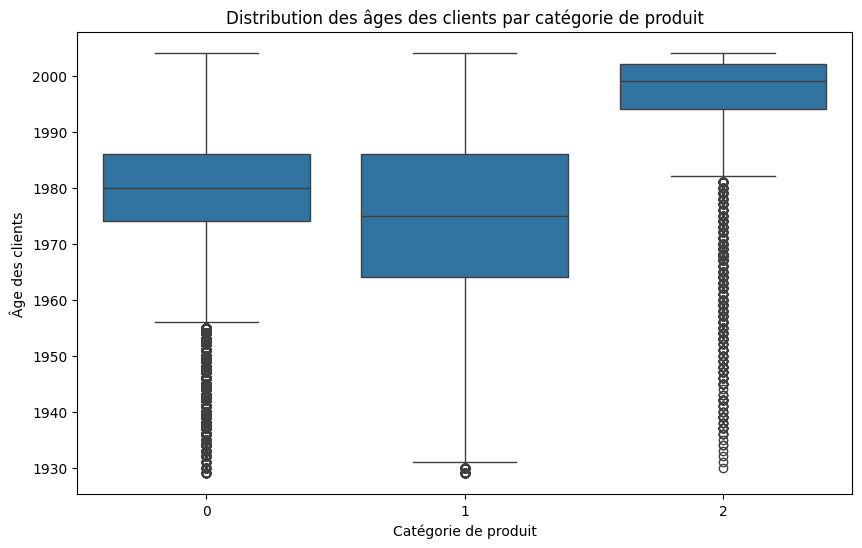

In [135]:
# Box plot montrant la distribution des âges des clients par catégorie de produit
plt.figure(figsize=(10, 6))
sns.boxplot(x='categ', y='birth', data=data)
plt.title('Distribution des âges des clients par catégorie de produit')
plt.xlabel('Catégorie de produit')
plt.ylabel('Âge des clients')
plt.show()


- Catégorie 0 : Les client de cette catégorie on une tranches d'age assez restreint, entre 1975 et 1985

- Catégorie 1 : Cette catégorie semble avoir une distribution d'âge plus large avec la plupart des clients étant d'âge moyen (peut-être entre 1965 et 1985 ).

- Catégorie 2 : Les clients de cette catégorie semblent être beaucoup plus jeunes en moyenne que ceux des deux autres catégories. Cependant, il y a une grande quantité d'outliers, ce qui indique une variation considérable parmi les clients qui achètent des produits de cette catégorie.